In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from oge.emissions import (
    return_monthly_plant_fuel_sulfur_content,
    return_monthly_national_fuel_sulfur_content,
    return_annual_national_fuel_sulfur_content,
)
from oge.load_data import load_pudl_table

# Get Sulfur Content for Years 2008 through 2022
Get sulfur content (in percent) at plant/month, ESC/month, ESC/year resolutions.

In [2]:
year = range(2008, 2023)
plant = {}
national = {}
annual = {}

for y in year:
    print(f"Processing {y}")
    plant[y] = return_monthly_plant_fuel_sulfur_content(y)
    national[y] = return_monthly_national_fuel_sulfur_content(y)
    annual[y] = return_annual_national_fuel_sulfur_content(y)

Processing 2008
Processing 2009
Processing 2010
Processing 2011
Processing 2012
Processing 2013
Processing 2014
Processing 2015
Processing 2016
Processing 2017
Processing 2018
Processing 2019
Processing 2020
Processing 2021
Processing 2022


## Annual Data
Here we consider the sulfur content for each energy source code and year combination.

In [3]:
for i, y in enumerate(year):
    if i == 0:
        all_annual = annual[y].rename(columns={"sulfur_content_pct": f"{y}"}).copy()
    else:
        all_annual = pd.merge(
            all_annual,
            annual[y].rename(columns={"sulfur_content_pct": f"{y}"}),
            how="outer",
            on="energy_source_code",
        )
display(all_annual)

,energy_source_code,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,AB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,ANT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BFG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,BIT,1.525359,1.513067,1.545337,1.613954,1.704587,1.759600,1.789805,1.825638,1.812482,1.846089,1.923561,1.892741,1.892603,1.959873,1.988477
4,BLQ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,DFO,0.132851,0.153376,0.127208,0.333333,0.173330,0.459167,0.500000,0.500000,0.500000,0.474167,0.500000,0.500000,0.500000,0.316667,0.440833
6,JF,0.100000,0.105625,0.046667,0.046667,NaN,NaN,0.500000,0.500000,NaN,NaN,NaN,0.500000,0.500000,0.500000,0.500000
7,KER,0.500000,0.500000,0.500000,NaN,NaN,NaN,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
8,LFG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,LIG,0.879623,0.919537,0.925800,0.912209,0.918571,0.897058,0.890983,0.867220,0.889003,0.894899,0.862958,0.917898,0.849416,0.856984,0.886214


### Plot Annual Average Across Years

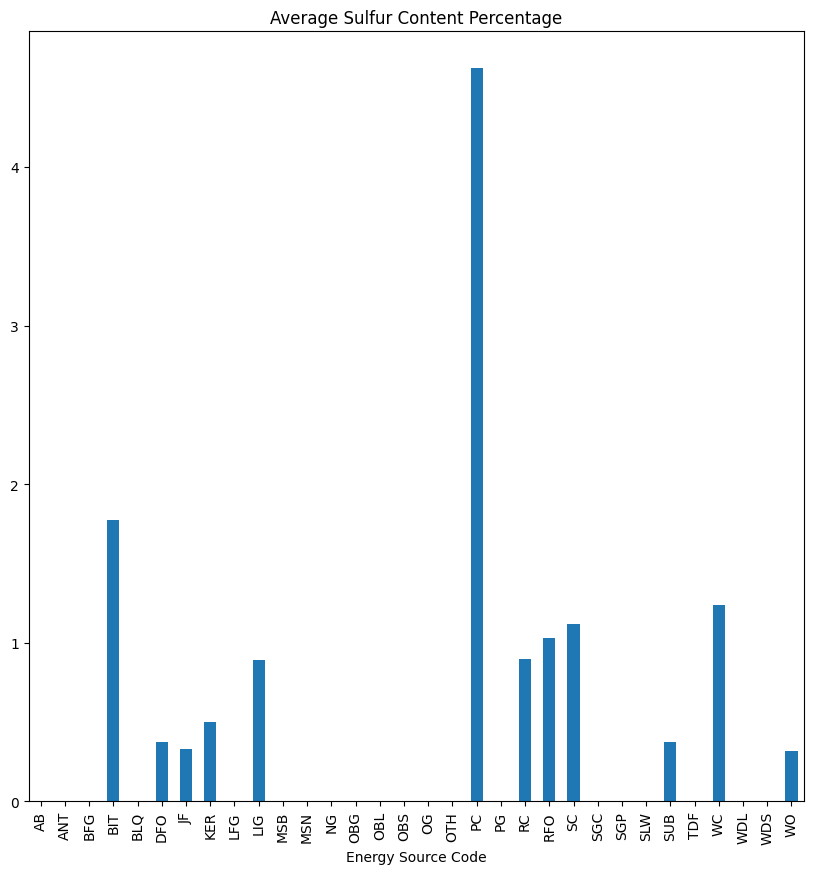

In [4]:
all_annual["average"] = all_annual.mean(axis=1, numeric_only=True, skipna=True)
all_annual.rename(columns={"energy_source_code": "Energy Source Code"}).plot(
    kind="bar",
    x="Energy Source Code",
    y="average",
    legend=False,
    title="Average Sulfur Content Percentage",
    figsize=(10, 10),
)
plt.show()

### Plot Annual for All Years
We only consider energy source code that are non-zero

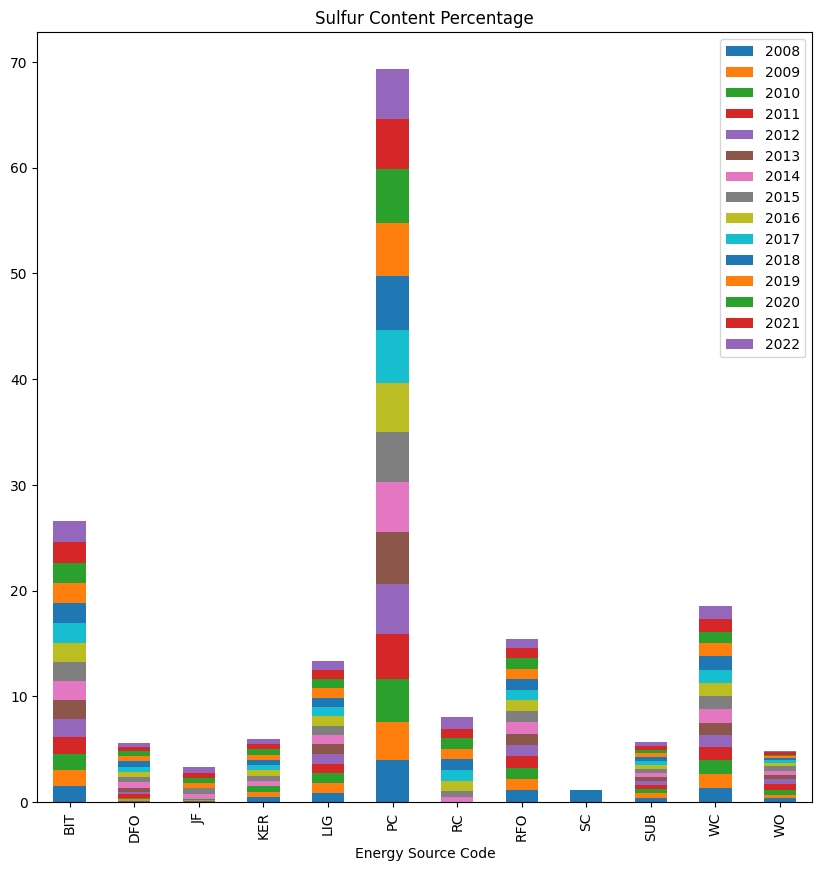

In [5]:
reduced_annual = all_annual[all_annual["average"] > 0]
reduced_annual.rename(columns={"energy_source_code": "Energy Source Code"}).drop(
    columns="average"
).plot(
    kind="bar",
    x="Energy Source Code",
    stacked=True,
    title="Sulfur Content Percentage",
    legend=year,
    figsize=(10, 10),
)
plt.show()

Sulfur content appears to be constant across years for each energy source code. Note that `SC` (coal-derived syngas) is non-zero for 2008 only.

## National Data
Here we consider sulfur content for each energy source code and for each report date across all years

In [6]:
for j, y in enumerate(year):
    national[y].insert(1, "month", national[y]["report_date"].dt.month)
    if j == 0:
        all_national = (
            national[y]
            .rename(columns={"sulfur_content_pct": f"{y}"})
            .drop(columns="report_date")
            .copy()
        )
    else:
        all_national = pd.merge(
            all_national,
            national[y]
            .rename(columns={"sulfur_content_pct": f"{y}"})
            .drop(columns="report_date"),
            how="outer",
            on=["energy_source_code", "month"],
        )
    national[y] = national[y].drop(columns="month")

display(all_national)

,energy_source_code,month,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,AB,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
1,AB,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
2,AB,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
3,AB,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
4,AB,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,WO,8,0.344800,0.354446,0.406048,0.485124,0.519762,0.297647,0.391765,0.319448,0.267758,0.269412,0.192632,0.108750,0.077143,0.192000,0.1150
380,WO,9,0.368261,0.346217,0.476682,0.436179,0.418307,0.264118,0.492632,0.291086,0.204515,0.205556,0.348947,0.155625,0.084286,0.232857,0.0475
381,WO,10,0.369500,0.347016,0.535466,2.424161,0.426445,0.418889,0.396471,0.275859,1.053359,0.223529,0.391053,0.443125,0.087692,0.203636,0.1110
382,WO,11,0.325714,0.347230,0.478208,0.471063,0.423998,0.285625,0.423333,0.259011,0.225867,0.190000,0.325000,0.185882,0.080769,0.238182,0.1460


### Plot National Data
Compare monthly data across years for each energy source code 

In [7]:
reduced_national = {
    e: all_national.query("energy_source_code == @e")
    .drop(columns="energy_source_code")
    .set_index("month")
    for e in reduced_annual["energy_source_code"].to_list()
}

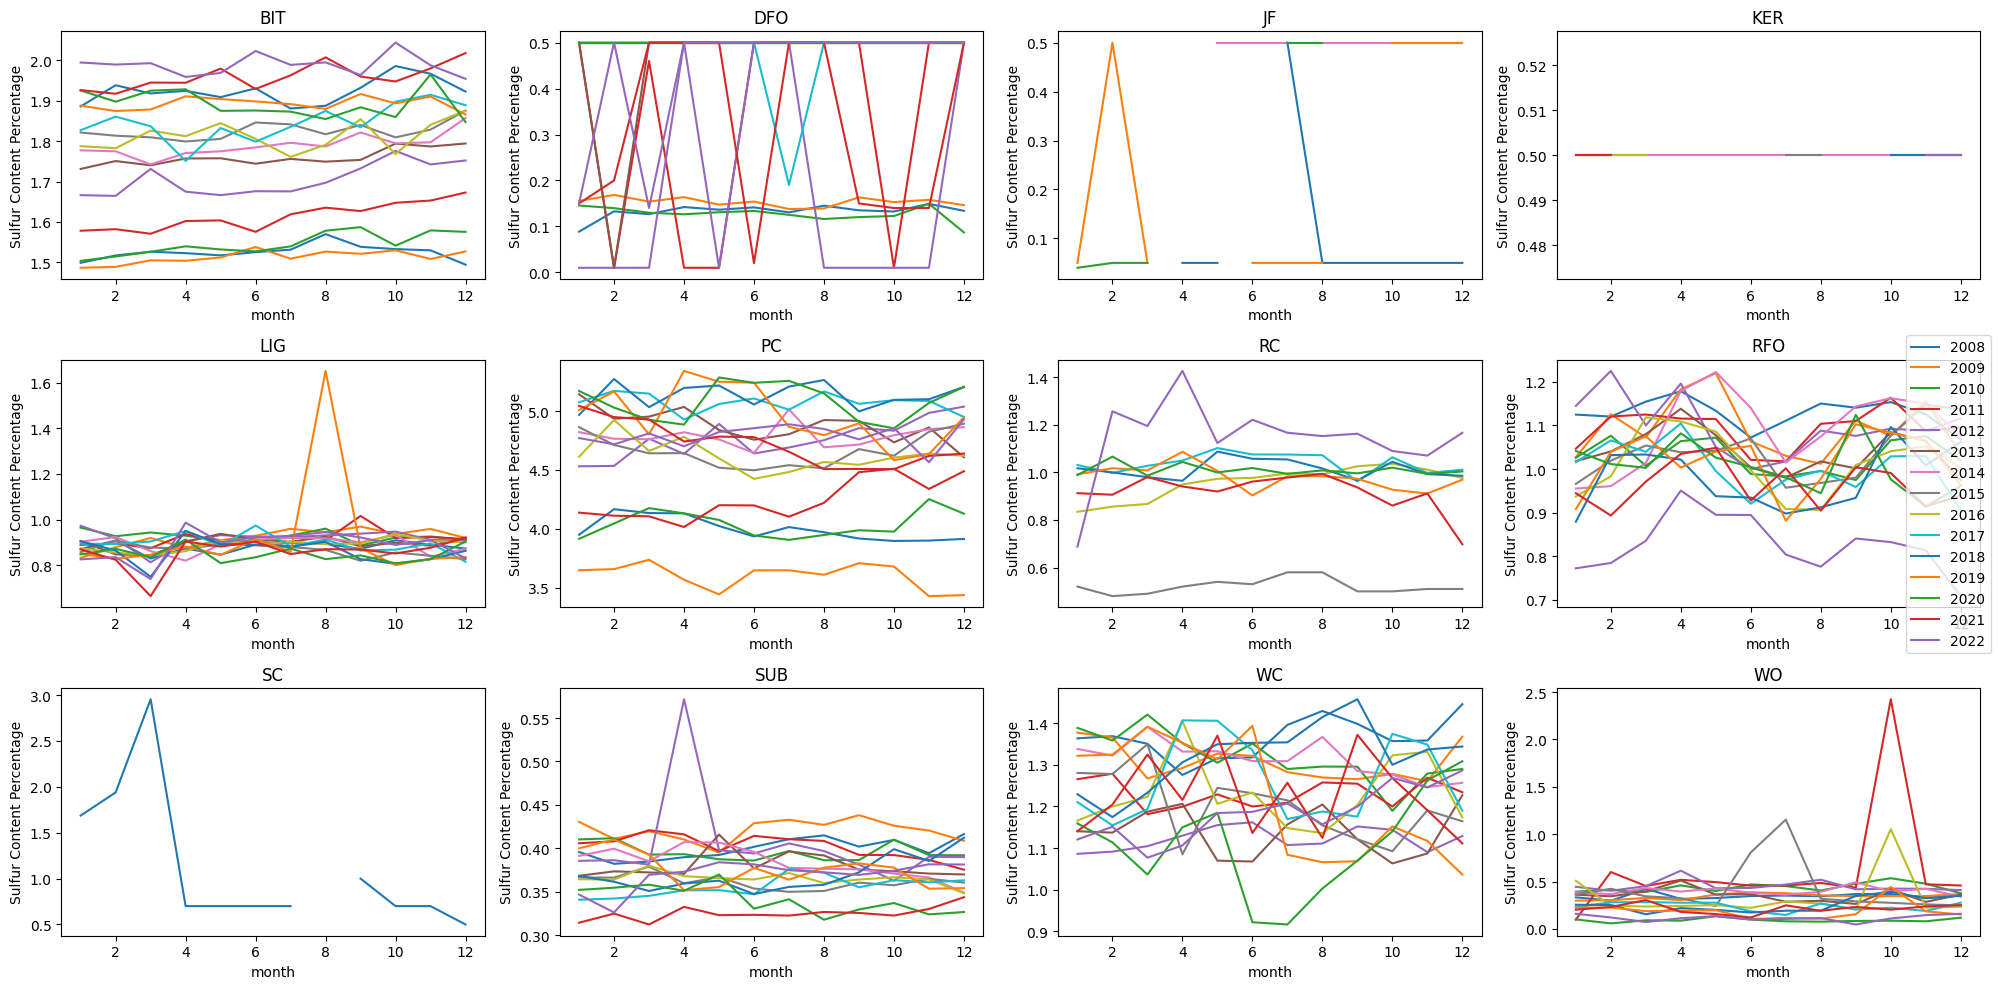

In [8]:
fig, axes = plt.subplots(ncols=4, nrows=3)
for e, ax in zip(reduced_national, axes.flatten()):
    reduced_national[e].plot(
        title=e,
        figsize=(20, 10),
        ylabel="Sulfur Content Percentage",
        ax=ax,
        legend=False,
    )

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc="center right")
fig.tight_layout()
plt.show()

To the exception of `KER` (Kerosene), monthly values vary across years and the variation is different from year-to-year.

## Plant Data
Let's focus on some `BIT` (Bituminous Coal) and `PC` (Petroleum Coke) plants as these fuel types have the most sulfur content.

In [9]:
for j, y in enumerate(year):
    plant[y].insert(1, "month", plant[y]["report_date"].dt.month)
    if j == 0:
        all_plant = (
            plant[y]
            .query("energy_source_code == 'BIT' or energy_source_code == 'PC'")
            .rename(columns={"sulfur_content_pct": f"{y}"})
            .drop(columns="report_date")
            .copy()
        )
    else:
        all_plant = pd.merge(
            all_plant,
            plant[y]
            .query("energy_source_code == 'BIT' or energy_source_code == 'PC'")
            .rename(columns={"sulfur_content_pct": f"{y}"})
            .drop(columns=["report_date", "prime_mover_code"]),
            how="outer",
            on=["plant_id_eia", "energy_source_code", "month"],
        )
    plant[y] = plant[y].drop(columns="month")

display(all_plant)

,plant_id_eia,month,energy_source_code,prime_mover_code,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,3,1,BIT,ST,0.494499,0.558054,0.519057,0.456092,0.607971,0.623635,0.538143,0.555967,0.496148,0.527337,0.577535,0.609290,NaN,NaN,0.729444
1,3,2,BIT,ST,5.000000,0.534285,0.560952,0.570926,0.616714,0.664798,0.530000,0.550000,0.500000,0.620000,0.561717,0.670344,0.530000,0.601909,0.582154
2,3,3,BIT,ST,0.490000,0.472087,0.583083,0.504323,0.506455,0.486735,0.530000,0.545605,0.466250,0.590000,0.497460,0.711977,0.640000,0.600000,0.670000
3,3,4,BIT,ST,0.496831,0.468351,0.579171,0.571299,0.394961,0.512912,0.515366,0.620000,0.510000,0.590000,0.519302,0.710000,0.647939,0.478117,0.770000
4,3,5,BIT,ST,0.520000,0.752452,1.291405,0.710204,0.586854,0.644530,0.620000,0.618166,0.523083,0.601699,NaN,0.683268,0.620000,0.458074,0.670000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6532,65285,8,BIT,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6533,65285,9,BIT,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6534,65285,10,BIT,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6535,65285,11,BIT,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Select `BIT` and `PC` Plants with Data for All years and at least 10 Months

In [10]:
all_plant_keep = all_plant[
    all_plant.select_dtypes(include=["number"]).notnull().all(axis=1)
]
display(all_plant_keep)

,plant_id_eia,month,energy_source_code,prime_mover_code,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
1,3,2,BIT,ST,5.000000,0.534285,0.560952,0.570926,0.616714,0.664798,0.530000,0.550000,0.500000,0.620000,0.561717,0.670344,0.530000,0.601909,0.582154
2,3,3,BIT,ST,0.490000,0.472087,0.583083,0.504323,0.506455,0.486735,0.530000,0.545605,0.466250,0.590000,0.497460,0.711977,0.640000,0.600000,0.670000
3,3,4,BIT,ST,0.496831,0.468351,0.579171,0.571299,0.394961,0.512912,0.515366,0.620000,0.510000,0.590000,0.519302,0.710000,0.647939,0.478117,0.770000
5,3,6,BIT,ST,0.460000,0.491789,0.543413,0.598240,0.679743,0.649539,0.616411,0.522787,0.522441,0.640000,0.570000,0.700000,0.570000,0.440000,0.740000
6,3,7,BIT,ST,0.460000,0.600728,0.429412,0.580000,0.626729,0.632591,0.610956,0.507049,0.490000,0.592295,0.586513,0.640000,0.610000,0.480000,0.620000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6240,54775,5,BIT,ST,2.246431,2.746712,2.187840,2.990984,2.780456,3.580000,1.923589,2.489244,2.441650,2.188415,2.820000,2.550000,2.870000,2.870000,2.910000
6241,54775,6,BIT,ST,2.568400,1.922508,2.165295,2.445616,2.732635,3.470000,2.266965,2.089114,2.494541,1.979258,3.070000,2.920000,2.860000,2.880000,3.080000
6247,54775,12,BIT,ST,2.312842,2.252032,2.250902,2.378050,2.933112,1.827401,2.204814,1.892363,3.270000,3.040000,1.580000,3.110000,2.940000,2.910000,2.810000
6249,54780,2,BIT,ST,3.320000,3.010000,2.980000,3.070000,3.220000,3.070000,3.000000,3.020000,3.090000,2.980000,2.960000,2.960000,2.850000,3.000000,3.010000


In [11]:
all_plant_keep_idx = (
    all_plant_keep[
        all_plant_keep.groupby("plant_id_eia")["month"].transform("size") >= 10
    ]
    .groupby(["energy_source_code"])["plant_id_eia"]
    .unique()
)

display(all_plant_keep_idx)

energy_source_code
BIT    [136, 525, 564, 703, 963, 976, 983, 994, 1012,...
PC                     [1393, 4125, 10361, 50121, 50305]
Name: plant_id_eia, dtype: object

### Plot Plant Data

In [12]:
bit_idx = np.random.choice(all_plant_keep_idx.loc["BIT"], size=1)[0]
pc_idx = np.random.choice(all_plant_keep_idx.loc["PC"], size=1)[0]

In [13]:
bit_idx

10495

In [14]:
bit_plant = all_plant_keep.set_index("plant_id_eia").loc[bit_idx].round(2)
display(bit_plant)

,month,energy_source_code,prime_mover_code,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
plant_id_eia,,,,,,,,,,,,,,,,,,
10495,1,BIT,ST,0.68,0.94,0.70,0.80,0.62,1.05,0.82,0.83,0.79,1.42,0.77,0.76,0.60,0.58,0.94
10495,2,BIT,ST,0.62,0.94,0.94,0.80,0.62,1.05,0.75,0.68,0.79,1.45,0.77,0.75,0.60,0.68,0.92
10495,3,BIT,ST,0.71,0.94,0.70,0.80,0.62,1.05,0.75,0.68,0.79,1.45,0.77,0.76,0.60,0.68,0.92
10495,4,BIT,ST,0.77,0.94,0.70,0.85,0.62,1.05,0.82,0.68,0.79,1.45,0.73,0.80,0.60,0.68,0.92
10495,5,BIT,ST,0.77,0.94,0.70,0.80,0.62,1.05,0.82,0.68,0.79,1.45,0.73,0.80,0.60,0.68,0.92
10495,6,BIT,ST,0.77,0.82,0.70,0.85,0.62,1.05,0.82,0.68,0.79,1.45,0.73,0.80,0.58,0.68,0.92
10495,7,BIT,ST,0.72,0.82,0.70,0.85,0.62,1.05,0.83,0.73,0.79,1.45,0.73,0.80,0.58,0.68,0.92
10495,8,BIT,ST,0.72,0.82,0.70,0.85,0.62,1.05,0.54,0.73,0.74,0.67,0.73,0.80,0.58,0.95,0.95
10495,9,BIT,ST,0.72,0.82,2.00,0.85,0.62,1.05,0.83,0.73,0.74,0.67,0.74,0.77,0.58,0.95,0.96


In [15]:
pc_plant = all_plant_keep.set_index("plant_id_eia").loc[pc_idx].round(2)
display(pc_plant)

,month,energy_source_code,prime_mover_code,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
plant_id_eia,,,,,,,,,,,,,,,,,,
1393,1,PC,ST,6.80,6.25,6.48,6.20,6.03,5.57,6.61,5.88,6.12,7.16,7.03,6.94,5.94,6.18,6.69
1393,2,PC,ST,6.85,6.69,7.00,5.88,6.23,5.78,5.48,5.87,6.22,7.31,7.11,6.76,5.94,6.40,6.76
1393,3,PC,ST,6.85,6.50,7.00,5.72,6.18,5.80,5.48,5.15,7.21,6.41,7.18,6.91,6.09,6.64,6.58
1393,4,PC,ST,6.70,5.85,7.00,5.88,5.64,5.90,6.34,4.83,6.87,6.31,7.55,6.80,5.98,6.14,6.58
1393,5,PC,ST,6.76,5.93,5.87,5.78,6.03,5.75,5.92,5.48,6.73,6.79,7.05,5.70,5.96,6.18,6.60
1393,6,PC,ST,6.77,6.25,6.50,5.53,6.23,6.06,6.07,6.16,6.20,6.86,7.01,5.20,6.92,6.23,6.18
1393,7,PC,ST,6.27,6.15,6.45,5.45,6.46,5.68,6.33,6.08,6.65,6.91,7.09,5.33,6.68,6.20,6.33
1393,8,PC,ST,6.49,6.08,5.72,6.05,6.01,5.78,5.42,5.47,7.06,6.97,6.83,5.20,6.33,6.12,6.48
1393,11,PC,ST,5.12,6.55,6.43,6.17,5.95,5.96,4.95,7.01,7.18,7.77,7.23,5.87,6.18,6.27,6.48


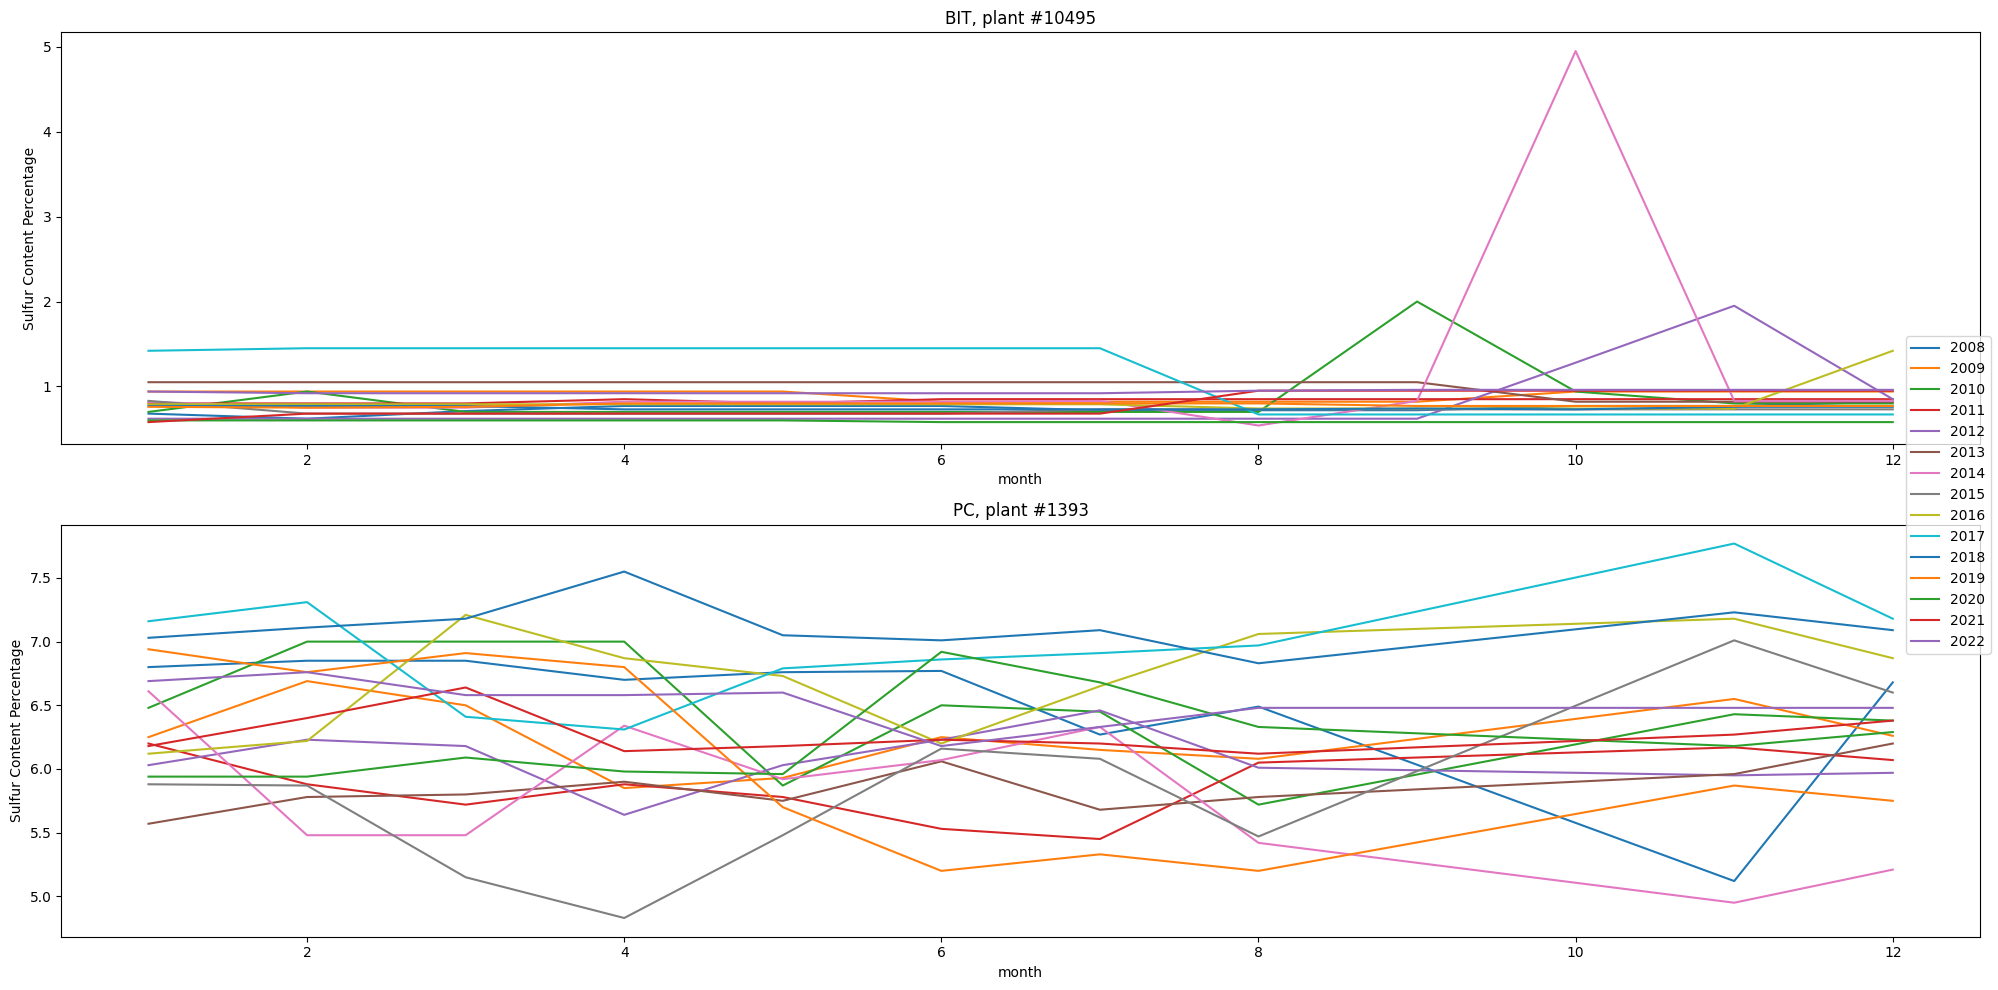

In [16]:
fig, axes = plt.subplots(2)
bit_plant.select_dtypes(include="number").plot(
    x="month",
    title=f"BIT, plant #{bit_idx}",
    ylabel="Sulfur Content Percentage",
    figsize=(20, 10),
    ax=axes[0],
    legend=False,
)
pc_plant.select_dtypes(include="number").plot(
    x="month",
    title=f"PC, plant #{pc_idx}",
    ylabel="Sulfur Content Percentage",
    figsize=(20, 10),
    ax=axes[1],
    legend=False,
)

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc="center right")
fig.tight_layout()
plt.show()

### State Level Average

In [17]:
plant_state = load_pudl_table(
    "core_eia__entity_plants", columns=["plant_id_eia", "state"]
)

In [18]:
esc_keep = reduced_annual["energy_source_code"].to_list()
for j, y in enumerate(year):
    plant[y].insert(1, "month", plant[y]["report_date"].dt.month)
    if j == 0:
        plant_average = (
            plant[y]
            .query("energy_source_code == @esc_keep")
            .rename(columns={"sulfur_content_pct": f"{y}"})
            .drop(columns="report_date")
            .copy()
        )
    else:
        plant_average = pd.merge(
            plant_average,
            plant[y]
            .query("energy_source_code == @esc_keep")
            .rename(columns={"sulfur_content_pct": f"{y}"})
            .drop(columns=["report_date", "prime_mover_code"]),
            how="outer",
            on=["plant_id_eia", "energy_source_code", "month"],
        )
    plant[y] = plant[y].drop(columns="month")

plant_average = (
    plant_average.drop(columns=["month", "prime_mover_code"])
    .groupby(["plant_id_eia", "energy_source_code"])
    .mean()
    .mean(axis=1)
)

display(plant_average)

plant_id_eia  energy_source_code
3             BIT                   0.599550
              SUB                   0.296858
              WC                         NaN
7             BIT                   1.693391
              DFO                   0.050000
                                      ...   
60084         RFO                   0.814386
60345         DFO                   0.449643
60356         DFO                        NaN
65285         BIT                        NaN
65978         DFO                        NaN
Length: 2027, dtype: float64

In [19]:
display(f"Number of plant with no sulfur content: {plant_average.isna().sum()}")

'Number of plant with no sulfur content: 265'

In [20]:
plant_average = plant_average.dropna()

In [21]:
display("Breakdown by energy source code:")
display(plant_average.reset_index()["energy_source_code"].value_counts())

'Breakdown by energy source code:'

energy_source_code
DFO    649
BIT    443
SUB    264
RFO    169
RC      70
PC      57
WO      41
WC      27
LIG     22
KER      9
SC       7
JF       4
Name: count, dtype: Int64

In [22]:
plant_average.name = "average_sulfur_content"
plant_average = plant_average.reset_index()
plant_average = pd.merge(plant_average, plant_state, on="plant_id_eia", how="left")

display(plant_average)

,plant_id_eia,energy_source_code,average_sulfur_content,state
0,3,BIT,0.599550,AL
1,3,SUB,0.296858,AL
2,7,BIT,1.693391,AL
3,7,DFO,0.050000,AL
4,8,BIT,1.325283,AL
...,...,...,...,...
1757,58310,PC,5.430000,LA
1758,58352,DFO,0.490779,WA
1759,58697,DFO,0.441667,NC
1760,60084,RFO,0.814386,GA


In [23]:
state_average = plant_average.groupby(["energy_source_code", "state"])[
    "average_sulfur_content"
].mean()

display(state_average)

energy_source_code  state
BIT                 AL       1.206751
                    AR       0.691833
                    AZ       0.494611
                    CA       0.725081
                    CO       0.475099
                               ...   
WO                  TX       0.032167
                    WA       0.336196
                    WI       0.000000
                    WV       0.250962
                    WY       0.237246
Name: average_sulfur_content, Length: 267, dtype: float64

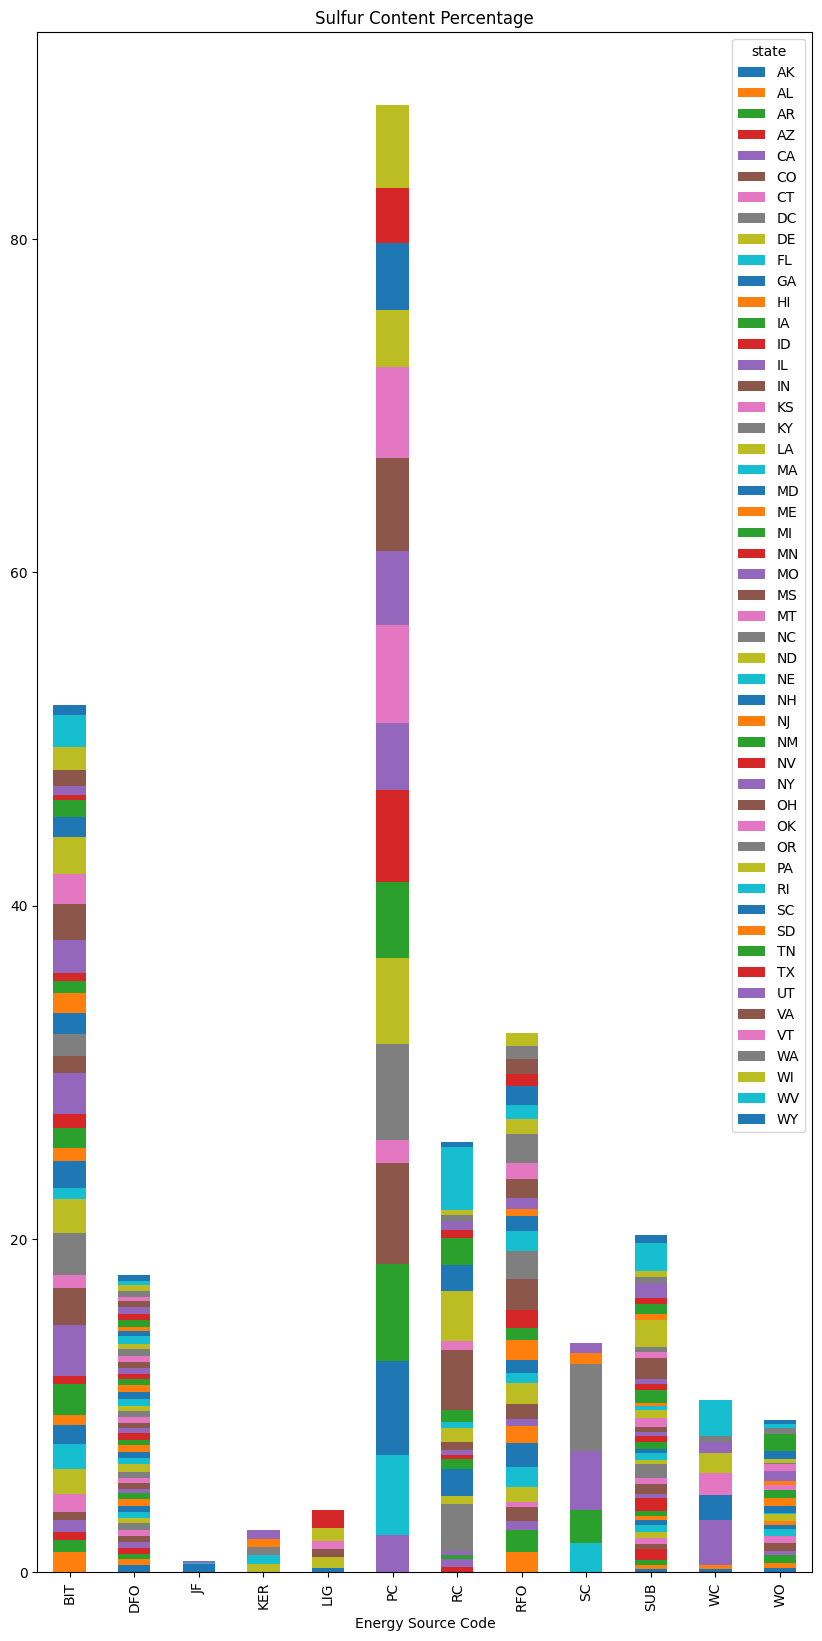

In [24]:
state_average.reset_index().rename(
    columns={"energy_source_code": "Energy Source Code"}
).pivot(
    columns="state", index="Energy Source Code", values="average_sulfur_content"
).plot(
    kind="bar",
    title="Sulfur Content Percentage",
    figsize=(10, 20),
    stacked=True,
)
plt.show()